In [328]:
# import and load modules
%reload_ext autoreload
%autoreload 2

import numpy as np; import pandas as pd; import math as math; import copy
from scipy.ndimage import gaussian_filter as gaussian_filter; import scipy.stats as stats
import statsmodels.api as sm; lowess = sm.nonparametric.lowess; from skimage import transform
from scipy import sparse

#mworks imports
from mworksbehavior import mwkfiles; from mworksbehavior.imaging import intrinsic as ii; import mworksbehavior as mwb; import mworksbehavior.mwk_io

import matplotlib as mpl; import matplotlib.pyplot as plt; import matplotlib.gridspec as gridspec; from matplotlib import cm; from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable #from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle; from matplotlib.patches import Rectangle

import os, sys; from glob import glob; from pathlib import Path; import pickle
import tifffile as tfl; from datetime import datetime

#local files and shorthand notations for assigning common functions to variable names
sys.path.append(Path('../src').resolve().as_posix()); 
import quietcell_select_fxns_all as qcsf
r_ = np.r_; a_ = np.asarray; n_ = np.newaxis

In [329]:
yr= '24'
animal_id = 'i5309'

if animal_id == 'i5214':
    dates = ['0710','0711','0712','0713','0714']
elif animal_id == 'i5309': 
    dates = ['0827','0828','0829','0830','0831']
elif animal_id == 'i5398':
    dates = ['0112','0113','0114','0115','0116'] 
    
dates_cell = ['pre']+dates+['post']
frs = ['stimFrs', 'blFrs']
rootdir = os.path.expanduser('~/data-local/'+animal_id)
file_path = os.path.join(rootdir,'bh-mc-reg')
mc_file_path = os.path.join(file_path,'mc')
reg_file_path = os.path.join(file_path,'reg')
file_path_suite2p = os.path.join(rootdir,'suite2p')

In [330]:
# Initializing necessary data structures
cell_masks = np.load(os.path.join(file_path,'cell_masks.npy')) # to make this go to the pre notebook and get the cell masks

#fluorescence dataframes
df_frs_reg = pd.DataFrame(index=frs, columns=dates) #registered framestacks [frs, sidelength, sidelength]
df_cells = pd.DataFrame(index=frs, columns=dates) # avg fluor for each cell during stim or BL
avg_fluor = pd.DataFrame(index=['fluor','dfof'], columns=dates) # frame averaged fluor 
isnan_test = pd.DataFrame(index=['all','any'],columns=dates)

day_aip = np.ndarray((5,256,256)) # store aip for each day

#dfof dataframes
df_dfof_pix = pd.DataFrame(index=['dfof'], columns=dates) # frame dfof [sidelength, sidelength]
df_dfof_pix_split = pd.DataFrame(index=['dfof'], columns=dates) # copy for split versions

df_dfof_cells = pd.DataFrame(index=['dfof'], columns=dates_cell) # cell dfof [cells]
df_dfof_cellmap = pd.DataFrame(index=['cell_map'], columns=dates_cell) # map of cells (put cells in location on fov)

In [331]:
#load pre and post cells and cellmaps
trained_ori_ind = 3

pre_cell_map = np.load(os.path.join(rootdir,'npys-pre/dFoF_map_maskV_pre_lseg.npy'))[trained_ori_ind,:,:] #only use the 90° map for this anal
df_dfof_cellmap.at['cell_map','pre'] = pre_cell_map #only use the 90° map for this anal
post_cell_map = np.load(os.path.join(rootdir,'npys-post/dFoF_map_maskV_post_lseg.npy'))[trained_ori_ind,:,:] #only use the 90° map for this anal
df_dfof_cellmap.at['cell_map','post'] = post_cell_map #only use the 90° map for this anal

# df_dfof_cells.at['dfof','pre'] = np.load(os.path.join(rootdir,'npys-pre/dfoFV_cell_pre_lseg.npy'))[:,trained_ori_ind] #only use the 90° map for this anal
# df_dfof_cells.at['dfof','post'] = np.load(os.path.join(rootdir,'npys-post/dfoFV_cell_post_lseg.npy'))[:,trained_ori_ind] #only use the 90° map for this anal

df_dfof_cells.at['dfof','pre'] = np.load(os.path.join(rootdir,'npys-pre/dfoFV_cell_pre_lseg.npy')) 
df_dfof_cells.at['dfof','post'] = np.load(os.path.join(rootdir,'npys-post/dfoFV_cell_post_lseg.npy'))

In [332]:
def _im_mask_and_avg(im,masks):
    '''applies a series of masks to an image stack and returns the average value of the
    image stack within each mask across all the frames in the stack; return shape of (nCell,nFrame)'''
    nFr, nRows, nCols = im.shape
    im_vect = np.reshape(im,(nFr,nRows*nCols))
    mask_vect = np.reshape(masks,(nRows*nCols,masks.shape[2]))
    mask_sizes = mask_vect.sum(axis=(0))

    mask_vect_sparse = sparse.csr_matrix(mask_vect)
    masked_im_sums = sparse.csr_matrix.dot(im_vect,mask_vect_sparse)
    masked_im_avgs = masked_im_sums/mask_sizes[n_,:] # shape (nFrame,nCell)

    return masked_im_avgs.T # shape (nCell,nFrame)

In [333]:
def generate_dfof_map_cell(cell_masks,dfoF_cell):

    nCell = cell_masks.shape[2]

    # generate map of avg dF/F for each cell mask
    nRows = cell_masks.shape[0]
    nCols = cell_masks.shape[1]
    dFoF_map_cell_masks = np.zeros((nCell,nRows,nCols))
    for iC in range(nCell):
        cell_map = dfoF_cell[iC] * cell_masks[:,:,iC]
        cell_map[cell_map==0] = np.nan
        dFoF_map_cell_masks[iC,:,:] = cell_map

    dFoF_map_mask = np.nanmin(dFoF_map_cell_masks,axis=0)
    
    return dFoF_map_cell_masks, dFoF_map_mask,cell_map

In [334]:
#make dataframe of image stacks and dataframe of cell average Fluor
for row in df_frs_reg.index:
    for col in df_frs_reg.columns:
        for file in os.listdir(reg_file_path):
            if row+'-'+col in file:
                df_frs_reg.at[row, col] = tfl.imread(os.path.join(reg_file_path,file)) #frame stack here; frs registered to eachother
                masks_frs = _im_mask_and_avg(df_frs_reg.at[row, col],cell_masks) 
                df_cells.at[row, col] = masks_frs.mean(axis=1) #avg F for each cell during stim or baseline

In [335]:
#dfof for fr and then for the cells
fr_store = [] # place to store frame count for each day
check_bl_zeros = []

for i, col in enumerate(df_frs_reg.columns):
    
    #do the frame one *CONNOR, this is where you edit, 
    #make an array or dataframe that doesn't take the mean across all stim frames, but instead splice it in to first and second half, etc.
    # I recommend just using all the baseline frames for a given day for all analysis, and only segregating th
    

    split_ind = int(np.ceil(df_frs_reg.at['stimFrs', col].shape[0]/2)) #taking ceil so extra frame will be in the first half 
    stim_fr = df_frs_reg.at['stimFrs', col].mean(axis=0)
    bl_fr = df_frs_reg.at['blFrs', col].mean(axis=0)
    
    df_dfof_pix.at['dfof', col] = (stim_fr-bl_fr)/(gaussian_filter(bl_fr,sigma=3))*100
    
    day_aip[i,:,:] = stim_fr
    
    
    # Adding version that is split 
    stim_fr_1 = df_frs_reg.at['stimFrs', col][:split_ind,:,:].mean(axis=0)
    stim_fr_2 = df_frs_reg.at['stimFrs', col][split_ind+1:,:,:].mean(axis=0)
    
    fr_store.append([len(df_frs_reg.at['stimFrs', col][:split_ind,:,:]),len(df_frs_reg.at['stimFrs', col][split_ind+1:,:,:])])

    df_dfof_pix_split.at['dfof', col] = [(stim_fr_1-bl_fr)/(gaussian_filter(bl_fr,sigma=3))*100, 
                                   (stim_fr_2-bl_fr)/(gaussian_filter(bl_fr,sigma=3))*100]
    
    #do the cell one
    stim_cell = df_cells.at['stimFrs', col]
    bl_cell = df_cells.at['blFrs', col]
    df_dfof_cells.at['dfof', col] = (stim_cell-bl_cell)/bl_cell*100

    #put the cells on a map
    dfof_for_cell_map = df_dfof_cells.at['dfof', col]
    dFoF_map_cell_masks,dFoF_map_mask,cell_map = generate_dfof_map_cell(cell_masks,dfof_for_cell_map)
    df_dfof_cellmap.at['cell_map', col] = dFoF_map_mask
        

/var/folders/jz/44sr7v096p1d9w_7_z1267br0000gs/T/ipykernel_8404/3370717781.py:14: RuntimeWarning: All-NaN slice encountered
  dFoF_map_mask = np.nanmin(dFoF_map_cell_masks,axis=0)


In [336]:
# Calculating averages
aip = day_aip.mean(axis=0)
dfof_avg = df_dfof_pix.loc['dfof'].mean(axis=0)

# Creating cell masks for dfof_avg
stim_cell = df_cells.loc['stimFrs'].mean(axis=0)
bl_cell = df_cells.loc['blFrs'].mean(axis=0)
avg_dfof_cells = (stim_cell-bl_cell)/bl_cell*100

dFoF_map_cell_masks,dFoF_map_mask,cell_map = generate_dfof_map_cell(cell_masks,avg_dfof_cells)
df_dfof_cellmap.at['cell_map', col] = dFoF_map_mask

/var/folders/jz/44sr7v096p1d9w_7_z1267br0000gs/T/ipykernel_8404/3370717781.py:14: RuntimeWarning: All-NaN slice encountered
  dFoF_map_mask = np.nanmin(dFoF_map_cell_masks,axis=0)


In [337]:
exp_params = pickle.load(open(os.path.join(file_path_suite2p,'expt_params.pkl'),'rb')); #print('\npre_params)

In [338]:
with qcsf.analysis_2p_general(file_path=file_path_suite2p,expt_params=exp_params) as q2pg:
    cell_coords,pattern_coords,conversion_factor = q2pg.calculate_cell_pattern_coords(rootdir,cell_masks,csv_pattern_filename='quiet.csv')
    stim_iC,nostim_iC,all_iC = q2pg.label_stimulated_cells(cell_coords,pattern_coords,radius_microns=10) #0.5 pix/um 2x; 0.616 pix/um 2.5x
    
print("how many stimulated cells?", len(stim_iC))
print("how many stimulated spots?", len(pattern_coords))

zoom = 2.5. Finding cell IDs within direct stimulation radius... Stimulated cell IDs found.
how many stimulated cells? 22
how many stimulated spots? 15


In [339]:
# Saving coords, dfof_avg and aip 
np.save(os.path.join(rootdir,'npys-bh/aip.npy'),aip)
np.save(os.path.join(rootdir,'npys-bh/dfof_avg.npy'),dfof_avg)
np.save(os.path.join(rootdir,'npys-bh/pattern_coords.npy'),pattern_coords)
np.save(os.path.join(rootdir,'npys-bh/cell_coords.npy'),cell_coords)

## Code for all animals

In [ ]:
# Loading in data for each animal
animals = ['i5214','i5398','i5309']

# Preallocating storage
pat_store = pd.DataFrame(index = animals, columns=['aip','avg dfof','pat coords','cell coords','stim ic'])

# Looping through animals 
for i,animal in enumerate(animals):
    rootdir = os.path.expanduser('~/data-local/'+animal)
    
    # need to load: coords, dfof_avg, aip 
    pat_store.at[animal,'aip'] = np.load(os.path.join(rootdir,'npys-bh/aip.npy'))
    pat_store.at[animal,'avg dfof'] = np.load(os.path.join(rootdir,'npys-bh/dfof_avg.npy'))
    pat_store.at[animal,'pat coords'] = np.load(os.path.join(rootdir,'npys-bh/pattern_coords.npy'))
    pat_store.at[animal,'cell coords'] = np.load(os.path.join(rootdir,'npys-bh/cell_coords.npy'))
    pat_store.at[animal,'stim ic'] = np.load(os.path.join(rootdir,'npys-pre/stim_iC.npy'))


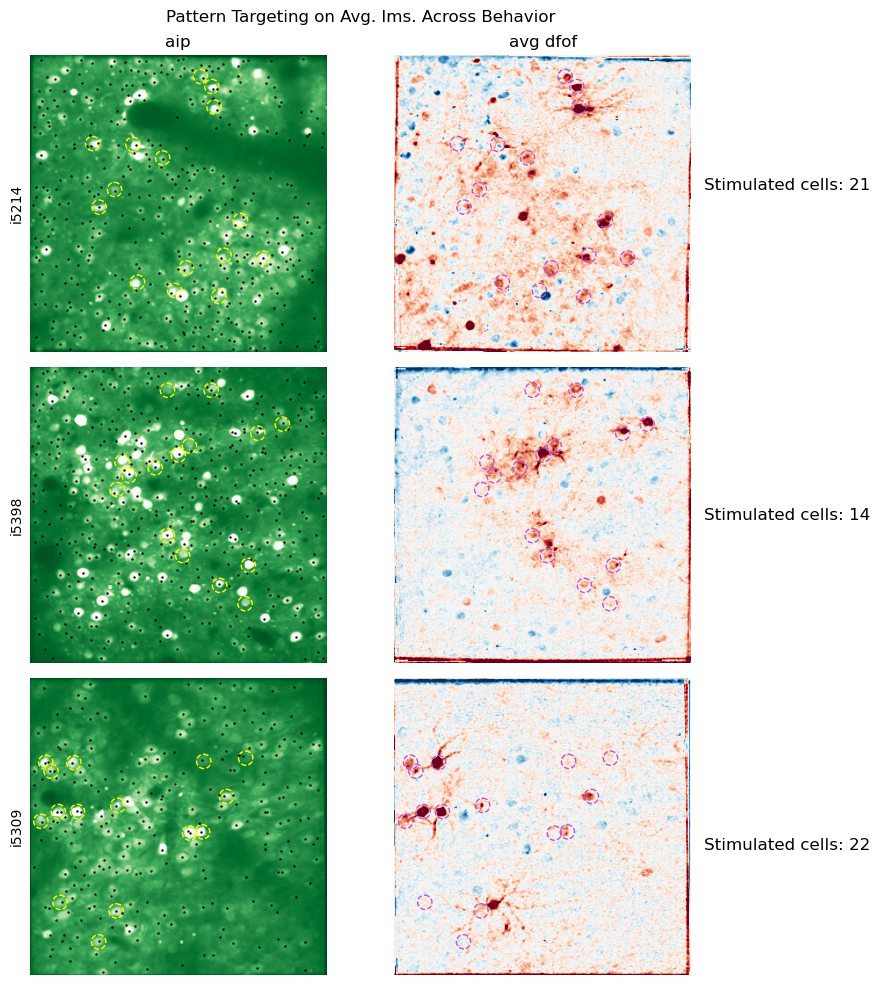

In [353]:
# Plotting aip and avg behave dfof with pattern coords after nonlinear transformation across days
# Goal is to assess pattern coordinate accuracy for identifying cells 

fig, ax = plt.subplots(3, 2, figsize=(8,10)); cl=30; f_clim = [300,500,200]

for i,animal in enumerate(animals):
    shift_x = 0
    shift_y = 0

    ax[i,0].imshow(pat_store.at[animal,'aip'],clim=(0,f_clim[i]),cmap='Greens_r')
    ax[i,0].set_ylabel(animal)
    ax[0,0].set_title('aip')
    ax[i,0].yaxis.set_tick_params(size=0);ax[i,0].set_xticks([]);ax[i,0].set_yticks([])
    ax[i,0].spines[['left','top','bottom','right']].set_visible(False)

    # Plotting stim spots
    for coords in pat_store.at[animal,'pat coords']:
        ax[i,0].add_patch( Circle((coords[0]+shift_x,coords[1]+shift_y),radius=10*conversion_factor,fill=False,ec='yellow',ls='--',lw=1,alpha=1) )
    
    # Plotting identified cells 
    ax[i,0].scatter(pat_store.at[animal,'cell coords'][:,0],pat_store.at[animal,'cell coords'][:,1],s=0.5,color='black')
        
        
    ax[i,1].imshow(pat_store.at[animal,'avg dfof'],clim=(-cl,cl),cmap='RdBu_r')
    ax[i,1].axis('off'); axes.set_xticks([]); axes.set_yticks([])
    ax[0,1].set_title('avg dfof')
    
    # Showing number of identified cells 
    fig.text(0.93,0.8 - 0.33 * i, f"Stimulated cells: {len(pat_store.at[animal,'stim ic'])}", ha='left', fontsize=12)


    for coords in pat_store.at[animal,'pat coords']:
        ax[i,1].add_patch( Circle((coords[0]+shift_x,coords[1]+shift_y),radius=10*conversion_factor,fill=False,ec='mediumorchid',ls='--',lw=1,alpha=1) )

fig.suptitle("Pattern Targeting on Avg. Ims. Across Behavior")
plt.tight_layout()
plt.show()
    # plt.subplots_adjust(wspace=0.05, hspace=0.1)
    #plt.savefig(os.path.join(rootdir,'top_changers_circled.png'), bbox_inches='tight', dpi=400)

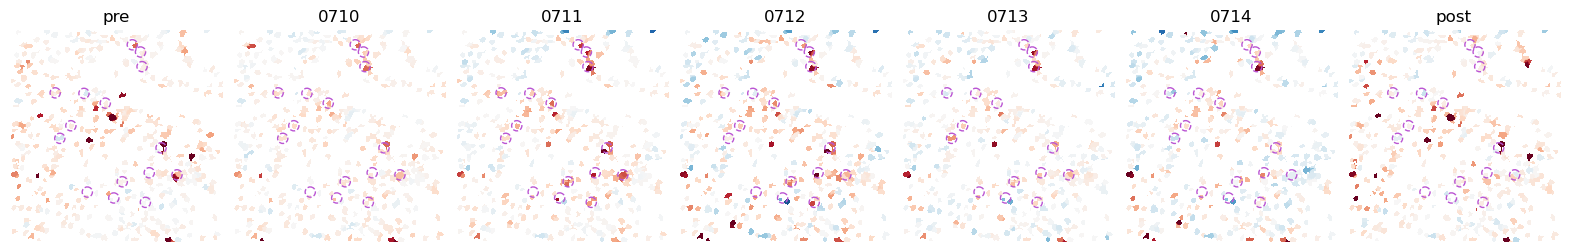

In [57]:
shift_x = 0
shift_y = 0
fig, ax = plt.subplots(1, 7, figsize=(20,6)); cl=40
for i,axes in enumerate(ax):
    axes.imshow(df_dfof_cellmap.iloc[0,i],clim=(-cl,cl),cmap='RdBu_r')
    axes.axis('off'); axes.set_xticks([]); axes.set_yticks([])
    for coords in pattern_coords:
        axes.add_patch( Circle((coords[0]+shift_x,coords[1]+shift_y),radius=10*conversion_factor,fill=False,ec='mediumorchid',ls='--',lw=1,alpha=1) )
    axes.set_title(df_dfof_cellmap.columns[i])
plt.subplots_adjust(wspace=0.05, hspace=0.1)
#plt.savefig(os.path.join(rootdir,'top_changers_circled.png'), bbox_inches='tight', dpi=400)